In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Recommendation systems: Deep Model

This model is made up of feature layers that have users, movies and movie genres embedings followed by a neural network with dense layers and finally one output that is the rating prediction that input user(id) could assign to input movie(id).

**Inputs**
* **User id**: Really this is traducet as a sequence because embedding layers only can manage sequenced identifiers.
* **Movie id**: Idem to User id.
* **Movie genres**: One column by genre.

**Output**
*  **Rating prediction** that user could assign to movie.

**Links**
* [Deep Learning With Keras: Recommender Systems](https://www.johnwittenauer.net/deep-learning-with-keras-recommender-systems/)
* [Collaborative Filtering for Movie Recommendations](https://keras.io/examples/structured_data/collaborative_filtering_movielens/)
* [Movie lens datasets](https://grouplens.org/datasets/movielens/)
* [Recommendation Systems Benchmarks](https://paperswithcode.com/task/recommendation-systems)

## Required libraries

In [1]:
import sys
sys.path.append('./src')

import numpy as np
import pandas as pd
import tensorflow as tf

from util import tf_detected_devices, tf_version, plot_model, Config, LoggerFactory
from callback import MetricsPlotter
from data import DataFrameDataGenerator
from recommendation import UserMovieGenderEmbeddingDenseModelFactory
from spark import SparkSessionFactory, read_csv, column_values, train_test_split, PageSet, get_columns, get_rows

import pyspark.sql.types as t
import pyspark.sql as s
import pyspark.sql.functions as f

## Logger config

In [3]:
config = Config(path='./config/config.yaml')
LoggerFactory(config['logger']).create()

<RootLogger root (INFO)>

## Config parameters

**Step 1**: Setup test_mode variable to enable or disable model train before check their prediction precision:

In [14]:
train_model = True

**Step 2**: Select a data set with a given size:

In [15]:
dataset_size = 'ml-latest' # 250MB
# dataset_size = 'ml-25m' # 25MB
# dataset_size = 'ml-latest-small' # 1MB

## Check environment

**Step 1**: Make sure that nvidia driver is installed runing next command:

In [5]:
!nvidia-smi --query-gpu=gpu_name,memory.total --format=csv | sed -n 2p

GeForce GTX 1060, 6078 MiB


**Note:** If this shows a GPU model and memory size, that's all right, otherwise make suze that has the nvidia driver installed.

**Step 2**: Let's check tensorflow version:

In [6]:
tf_version()

'Tensorflow version: 2.5.0-dev20201029'

**Step 3**: Let's check devices that tensorflow detect:

In [3]:
tf_detected_devices()

,Name,Device Type,Memory,Description
0,/device:CPU:0,CPU,256M,
1,/device:GPU:0,GPU,5G,"device: 0, name: GeForce GTX 1060, pci bus id:..."


In [4]:
tf.debugging.set_log_device_placement(False)

**Step 4**: Make sure that tensorflow detect cuda libs and GPU devices.

In [5]:
tf.test.is_built_with_cuda()

True

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Prepare model input data

**Step 1**: Create a predefined spack session. this is used to create a pipeline that build the model input features. 

In [7]:
session = SparkSessionFactory.create()
session

**Note**: When create a spark session this run a new spark cluster with one instance in localhost. You can monitor instance jobs clicking the **Spark UI** link. 

**Step 2**: Load raw dataset to a spark dataset. 

In [26]:
dataset = read_csv(session, './dataset/*.csv')

**Step 2**: Get all users and movies ids and let's see how many elements has each.

In [27]:
n_users, n_movies = dataset.select('user_id').distinct().count(), dataset.select('movie_id').distinct().count()

In [28]:
print('Users count:', n_users, '\nMovies count: ', n_movies)

Users count: 610 
Movies count:  9724


**Step 3:** Let's see min and max value of rating column.

In [31]:
min_max = dataset.agg(f.min('rating'), f.max('rating')).collect()[0]
min_rating, max_rating = min_max[0], min_max[1]

In [32]:
print('Ratting - min: ', min_rating, 'max:', max_rating)

Ratting - min:  0.5 max: 5.0


**Step 3:** Let's see all dataset columns.

In [30]:
dataset.columns

['rating',
 'user_id',
 'movie_id',
 'gen_fantasy',
 'gen_adventure',
 'gen_none',
 'gen_comedy',
 'gen_film_noir',
 'gen_musical',
 'gen_thriller',
 'gen_romance',
 'gen_western',
 'gen_mystery',
 'gen_sci_fi',
 'gen_action',
 'gen_documentary',
 'gen_imax',
 'gen_drama',
 'gen_animation',
 'gen_horror',
 'gen_crime',
 'gen_war',
 'gen_children',
 'user_seq',
 'movie_seq']

In [12]:
class ColumnService:
    def __init__(self, columns):
        excluded_columns = ['user_id', 'movie_id']
        self.labels = ['rating']

        self.features = list(set(columns) - set(self.labels) - set(excluded_columns))
        self.features = sorted(self.features, key=lambda x: 'gen_' in x)

        self.gender_features = [c for c in self.features if 'gen_' in c]
        self.emb_features = [c for c in self.features if '_seq' in c]
        self.emb_features = sorted(self.emb_features, key=lambda x: 'user' in x, reverse=True)

column_manager = ColumnService(ratings.columns)

In [13]:
column_manager.gender_features

['gen_film_noir',
 'gen_animation',
 'gen_war',
 'gen_drama',
 'gen_none',
 'gen_horror',
 'gen_action',
 'gen_children',
 'gen_musical',
 'gen_fantasy',
 'gen_comedy',
 'gen_adventure',
 'gen_romance',
 'gen_documentary',
 'gen_sci_fi',
 'gen_imax',
 'gen_western',
 'gen_mystery',
 'gen_thriller',
 'gen_crime']

In [18]:
column_manager.emb_features

['user_seq', 'movie_seq']

In [19]:
train, val = train_test_split(ratings, test_size=0.3)
train.take(1), val.take(1)

([Row(rating=0.5, user_id=3, movie_id=31, gen_fantasy=0, gen_adventure=0, gen_none=0, gen_comedy=0, gen_film_noir=0, gen_musical=0, gen_thriller=0, gen_romance=0, gen_western=0, gen_mystery=0, gen_sci_fi=0, gen_action=0, gen_documentary=0, gen_imax=0, gen_drama=1, gen_animation=0, gen_horror=0, gen_crime=0, gen_war=0, gen_children=0, user_seq=2, movie_seq=259)],
 [Row(rating=0.5, user_id=3, movie_id=527, gen_fantasy=0, gen_adventure=0, gen_none=0, gen_comedy=0, gen_film_noir=0, gen_musical=0, gen_thriller=0, gen_romance=0, gen_western=0, gen_mystery=0, gen_sci_fi=0, gen_action=0, gen_documentary=0, gen_imax=0, gen_drama=1, gen_animation=0, gen_horror=0, gen_crime=0, gen_war=1, gen_children=0, user_seq=2, movie_seq=28)])

In [20]:
train_size, val_size = train.count(), val.count()

In [21]:
import math

if dataset_size == 'ml-latest':
    steps  = 3
    epochs = 70
    plot_interval = math.floor(steps / 3)
elif dataset_size == 'ml-25m':
    steps  = 20
    epochs = 20
    plot_interval = math.floor(steps / 5)
else:
    steps  = 200
    epochs = 20
    plot_interval = math.floor(steps / 5)

batch_size        = math.floor(train_size / steps)
val_batch_size    = math.floor(val_size / steps)
evaluate_interval = plot_interval + 1

print('Train Batch Size     :', batch_size)
print('Validation Batch Size:', val_batch_size)
print('Plot Interval        :', plot_interval)
print('Evaluate Interval    :', evaluate_interval)

Train Batch Size     : 23551
Validation Batch Size: 10060
Plot Interval        : 1
Evaluate Interval    : 2


In [22]:
train_page_set = PageSet(train, page_size=5)

In [23]:
train_page_set.get(1, True).select('row_seq', 'user_seq', 'movie_seq').show()

+-------+--------+---------+
|row_seq|user_seq|movie_seq|
+-------+--------+---------+
|      5|       2|      267|
|      6|       2|      120|
|      7|       2|      271|
|      8|       2|      128|
|      9|       2|      273|
+-------+--------+---------+



In [24]:
train_page_set = train_page_set.shuffled()

In [25]:
train_page_set[0].select('user_seq', 'movie_seq').show()

+--------+---------+
|user_seq|movie_seq|
+--------+---------+
|      67|     3297|
|     407|      198|
|     166|      865|
|     527|     3094|
|     159|      753|
+--------+---------+



In [26]:
class RecommendationsDataGenerator(DataFrameDataGenerator):    
    def _features(self, page, columns):
        emb1 = get_rows(page, column_manager.emb_features[0])
        emb2 = get_rows(page, column_manager.emb_features[1])
        genders = get_rows(page, column_manager.gender_features)
        return [emb1, emb2, genders]

In [27]:
generator = RecommendationsDataGenerator(
    train,
    column_manager.features,
    column_manager.labels,
    batch_size=5,
    shuffle=True
)

X, y = generator[0]

In [28]:
y, y.shape

(array([[3.],
        [4.],
        [2.],
        [3.],
        [5.]]),
 (5, 1))

In [29]:
X[0], X[0].shape

(array([[394],
        [576],
        [197],
        [604],
        [  7]]),
 (5, 1))

In [30]:
X[1], X[1].shape

(array([[ 531],
        [ 191],
        [1171],
        [5213],
        [ 460]]),
 (5, 1))

In [31]:
X[2], X[2].shape

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]),
 (5, 20))

In [32]:
train_generator = RecommendationsDataGenerator(
    train, 
    column_manager.features,
    column_manager.labels,
    batch_size, 
    shuffle=True,
    name='train'
)

In [33]:
val_generator = RecommendationsDataGenerator(
    val,
    column_manager.features,
    column_manager.labels,
    val_batch_size,
    shuffle=False,
    name='val'
)

In [34]:
model = UserMovieGenderEmbeddingDenseModelFactory.create(
    n_users, 
    n_movies,
    n_genders=len(column_manager.gender_features),
    min_rating=min_rating, 
    max_rating=max_rating,
    units=[2048, 1024],
    dropout=[0.1, 0.1]
)

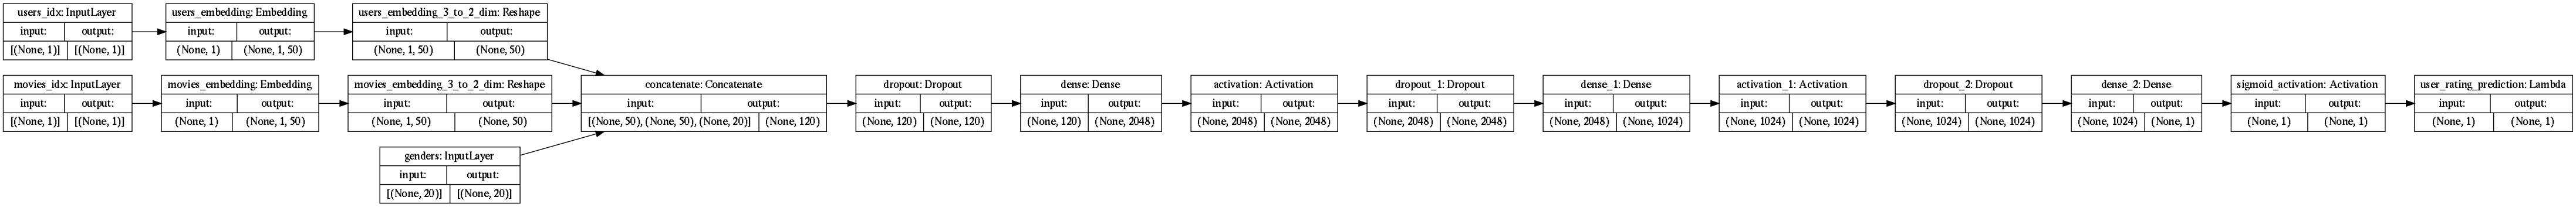

In [35]:
plot_model(model)

In [36]:
model.summary()

Model: "Embedding_Feature_Layers_Plus_Dense_Layer_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
users_idx (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
movies_idx (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
users_embedding (Embedding)     (None, 1, 50)        30500       users_idx[0][0]                  
__________________________________________________________________________________________________
movies_embedding (Embedding)    (None, 1, 50)        486200      movies_idx[0][0]                 
____________________________________________________

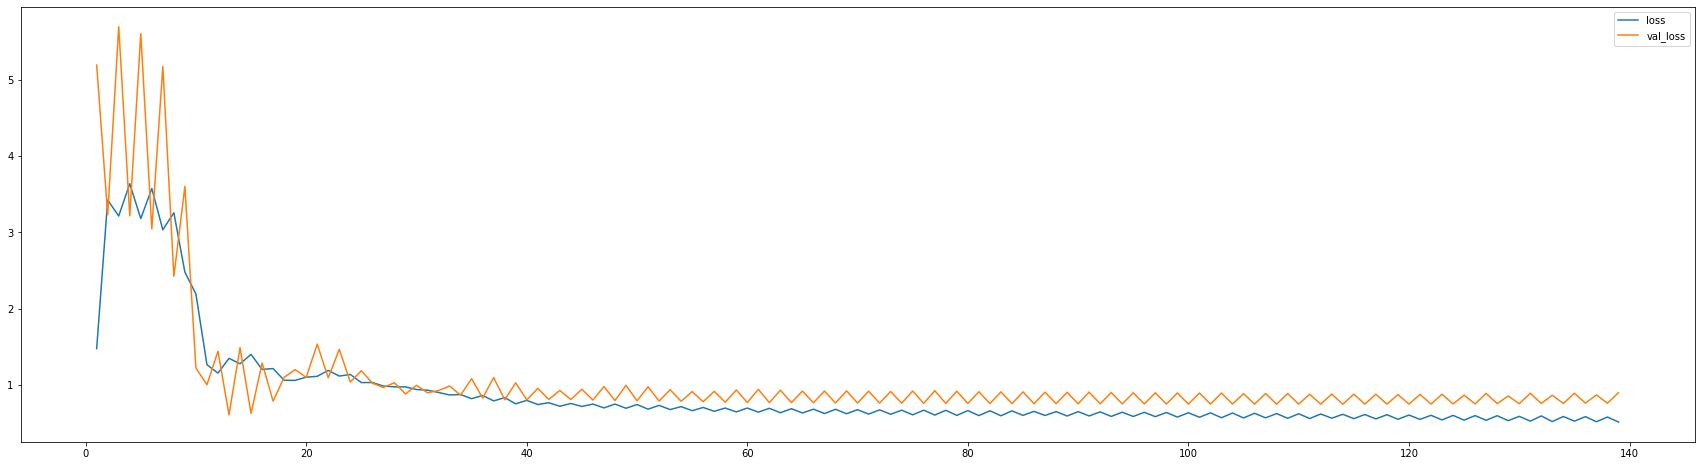



Evaluate model each 2 steps(Batch-size: 10060):
1/1 [==============================] - 0s 37ms/step - loss: 0.7661

Val metrics:
  - Loss (140): 0.766145 (⟱ 0.13005191)

Continue model train:
3/3 [==============================] - 63s 28s/step - loss: 0.5760 - val_loss: 0.7616


In [37]:
if train_model:
    history = model.fit_generator(
        generator=train_generator,
        validation_data=val_generator,
        epochs=epochs,
        verbose=1, 
        callbacks=[
            MetricsPlotter(
                validation_generator=val_generator, 
                metrics_names=['loss'],
                plot_interval=plot_interval,
                evaluate_interval=evaluate_interval,
                batch_size=batch_size,
                val_batch_size=val_batch_size
            )
        ]
    )

Check model loss after training process:

In [38]:
def evaluate_xy_model(model, column_manager, data_frame, batch_size):
    data_generator = RecommendationsDataGenerator(
        data_frame,
        column_manager.features,
        column_manager.labels,
        data_frame.count(),
        shuffle=False
    )
    X, y = data_generator[0]
    return model.evaluate(X, y, batch_size=batch_size, verbose=0)

In [41]:
val_loss = evaluate_xy_model(model, column_manager, val, batch_size)
val_loss

0.7616989612579346

Save the weights tthat model has learned:

In [42]:
WEIGHTS_PATH = f'./weights/user_movie_genders_deep_model_weights_{dataset_size}_val_loss_{val_loss}.h5'

model.save_weights(WEIGHTS_PATH) if train_model else model.load_weights(WEIGHTS_PATH)

### Check rating prediction

In [ ]:
import random

class UserMovieIdxPairGenerator:
    def __init__(self, train_set, dataset):
        self.__train_input = pd.DataFrame(train_input, columns=['user', 'movie'])
        self.__dataset = dataset

    def rand_user_idx(self): return random.choice(self.__train_input['user'])
 
    def rand_movie_idx(self): return random.choice(self.__train_input['movie'])
 
    def generate(self, has_rating=True):
        finish = True
        user_idx, movie_idx = None, None
        while finish:
            user_idx, movie_idx = self.rand_user_idx(), self.rand_movie_idx()
            pair = self.__dataset.rating_of(user_idx, movie_idx)
            finish = pair.empty if has_rating else not pair.empty
        return user_idx, movie_idx